## Download the Dataset 💾
Linux 환경에서만 실행 가능, Windows에서는 별도 다운로드 필요

In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb1hztk047VFk2j9bI7JKmEBtkWpABZ8vfX5_m0cdSjQHw?download=1 -O custom_korean_family_dataset_resolution_256.zip

In [2]:
import shutil

shutil.rmtree("/content/custom_korean_family_dataset_resolution_256")

FileNotFoundError: ignored

In [3]:
!unzip custom_korean_family_dataset_resolution_256.zip -d ./custom_korean_family_dataset_resolution_256

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_c1.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_c2.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_d1.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_d2.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_d3.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_e1.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_e2.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_e3.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_f1.jpg  
  inflating: ./custom_korean_family_dataset_resolution_256/train_images/F0182_AGE_F_55_f2.jpg  
  in

In [4]:
import zipfile
         
# image_zip = zipfile.ZipFile('D:\논문\custom_korean_family_dataset_resolution_256.zip')
# image_zip.extractall('D:\논문\custom_korean_family_dataset_resolution_256')
 
# image_zip.close()

## 라이브러리 설치

In [1]:
!pip install facenet_pytorch

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import random
import os
from PIL import Image
from torch.utils.data import Dataset

import torch
import torch.nn as nn

from facenet_pytorch import InceptionResnetV1
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Parsing 🔪

In [3]:
"""
> [Function] Parse the metadata.
* family_list = ["F0001", "F0002", ...]
* family_to_person_map["F0001"] = ["D", "GM", "M"]
* person_to_image_map["F0001_D"] = [
    "F0001_AGE_D_18_a1.jpg",
    "F0001_AGE_D_18_a2.jpg",
    ...
]
"""
def parsing(metadata):
    family_set = set()
    family_to_person_map = dict()
    person_to_image_map = dict()
    # iterate all rows in the metadata file
    for idx, row in metadata.iterrows():
        family_id = row["family_id"]
        person_id = row["person_id"]
        key = family_id + "_" + person_id
        image_path = row["image_path"]
        if family_id not in family_set:
            family_set.add(family_id)
            family_to_person_map[family_id] = []
        if person_id not in family_to_person_map[family_id]:
            family_to_person_map[family_id].append(str(person_id))    
            person_to_image_map[key] = []
        person_to_image_map[key].append(image_path) # save all image paths
    family_list = list(family_set)
    return family_list, family_to_person_map, person_to_image_map

Load Datasets
Training dataset
(F0001 ~ F0299) folders have 10,025 images.
Validation dataset
(F0801 ~ F0850) folders have 1,539 images.
Test dataset
(F0851 ~ F0900) folders have 1,504 images.

## <b>Configuration ⚙</b>
* 모델의 기본적인 설정들을 수정할 수 있습니다.

In [15]:
wts = [200,1,0.005] #세대 차이에 따른 가중치. 순서대로 동일,1세대,2세대 차이
dataloader_batch_size = 32 #배치 크기
log_step = 20 #log가 출력되는 주기(단위 : 배치)
model_count = 5 #앙상블할 모델 수
model_path = "models/" #모델의 경로

아래의 값들은 수정 가능하지만 가급적 수정하지 않는 것을 권장드립니다.

In [5]:
change = {'D':0,'D2':0,'D3':0,'D4':0,'S':0,'S2':0,'S3':0,'S4':0,'F':1,'M':1,'GF':2,'GM':2} #지위별 세대 번호

## Dataset

In [6]:
class TrainDataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        #print("인잇")
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        family_list, family_to_person_map, person_to_image_map = parsing(meta_data)
        self.family_list = family_list
        self.family_to_person_map = family_to_person_map
        self.person_to_image_map = person_to_image_map

    def __len__(self):
        #print("leng")
        return len(self.meta_data) * 2
               
    def __getitem__(self, idx):
        #print("hmm")
        # positive samples (family)
        if idx % 2 == 0:
            # choice a single family
            family_id = random.choice(self.family_list)
            # choice 2 different person in a single family
            p1, p2 = random.sample(self.family_to_person_map[family_id], 2) 
            #print("yeah complete")
            key1 = family_id + "_" + p1
            key2 = family_id + "_" + p2
            label = 1
        # negative samples (not family)
        else:
            # choice 2 different familiy
            f1, f2 = random.sample(self.family_list, 2)
            # choice a person in each family
            p1 = random.choice(self.family_to_person_map[f1])
            p2 = random.choice(self.family_to_person_map[f2])
            #print("yeah complete")
            key1 = f1 + "_" + p1
            key2 = f2 + "_" + p2
            label = 0
        #print("p1/p2 complete")

        path1 = random.choice(self.person_to_image_map[key1])
        path2 = random.choice(self.person_to_image_map[key2])
        #print("path1/path2 complete")

        v1 = change[path1.split('_')[2]]
        v2 = change[path2.split('_')[2]]
        weight=wts[abs(v1-v2)] # 가중치 파트
        #print("weight complete")

        img1 = Image.open(os.path.join(self.image_directory, path1))
        img2 = Image.open(os.path.join(self.image_directory, path2))
        #print("img1/img2 complete")

        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)
        
        return img1, img2, label, weight

In [7]:
class EvaluationDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.positive_folder = os.path.join(image_directory, "positive")
        self.negative_folder = os.path.join(image_directory, "negative")
        self.positive_list = os.listdir(self.positive_folder)
        self.negative_list = os.listdir(self.negative_folder)
        self.transform = transform

    def __len__(self):
        return len(self.positive_list) + len(self.negative_list)

    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            result_folder = os.path.join(self.positive_folder, self.positive_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 1

        #negative samples (not family)
        
        else:
            result_folder = os.path.join(self.negative_folder, self.negative_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 0

        v1 = change[file1.split('_')[2]]
        v2 = change[file2.split('_')[2]]
    
        weight=wts[abs(v1-v2)] # 가중치 파트

        img1 = Image.open(os.path.join(result_folder, file1))
        img2 = Image.open(os.path.join(result_folder, file2))
        
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)

        return img1, img2, label, weight

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_meta_data_path = "custom_korean_family_dataset_resolution_256/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "custom_korean_family_dataset_resolution_256/train_images"

val_image_directory = "custom_korean_family_dataset_resolution_256/fixed_val_dataset"
test_image_directory = "custom_korean_family_dataset_resolution_256/fixed_test_dataset"

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = TrainDataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=dataloader_batch_size, shuffle=True, num_workers=0)

val_dataset = EvaluationDataset(val_image_directory, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=dataloader_batch_size, shuffle=False, num_workers=0)

test_dataset = EvaluationDataset(test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=dataloader_batch_size, shuffle=False, num_workers=0)

In [9]:
!pip install matplotlib

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


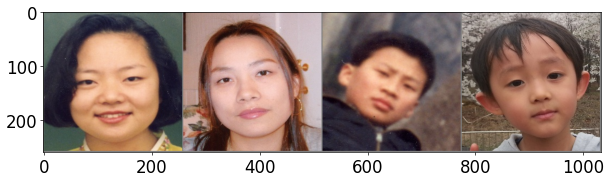

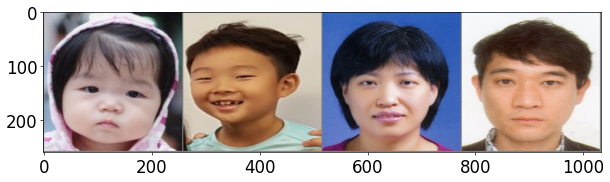

tensor([1, 0, 0, 1])


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
img1, img2, label, weight = next(iterator)
out = torchvision.utils.make_grid(img1[:4])
imshow(out)
out = torchvision.utils.make_grid(img2[:4])
imshow(out)
print(label[:4]) # 1: family, 0: not family

In [11]:
!pip install validators matplotlib

Using legacy 'setup.py install' for validators, since package 'wheel' is not installed.
    Running setup.py install for validators: started
    Running setup.py install for validators: finished with status 'done'


You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


## Model

In [12]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [13]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = InceptionResnetV1(pretrained='vggface2')
        self.emb_dim = 512

        self.last = nn.Sequential(
            nn.Linear(4 * self.emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, input1, input2):
        emb1 = self.encoder(input1)
        emb2 = self.encoder(input2)
        
        x1 = torch.pow(emb1, 2) - torch.pow(emb2, 2)
        x2 = torch.pow(emb1 - emb2, 2)
        x3 = emb1 * emb2
        x4 = emb1 + emb2
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.last(x)

        return x

## Test

In [16]:
models = []
for i in range(model_count):
    model = SiameseNet()
    model = nn.DataParallel(model)
    model.cuda()
    state_dict = torch.load(f"{model_path}best_checkpoint_epoch_{i+1}.pth") #모델의 경로는 반드시 이 경로대로 저장되어 있어야 함
    model.load_state_dict(state_dict)
    
    models.append(model) #모델을 불러와서 models에 추가

In [17]:
import time

In [18]:
criterion = nn.BCEWithLogitsLoss()
sigmoid = nn.Sigmoid()

In [21]:
def test():
    start_time = time.time()
    print(f'[Epoch: {1} - Test]')
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):

        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.cuda()
        
        outputs = 0
        preds = 0
        
        for model in models: #모든 모델에 대해
            model.eval()
            with torch.no_grad():
                output = model(img1, img2)
                preds += sigmoid(output) / len(models) #0~1으로 변환된 예측값을 모델 수로 나눠 추가(즉, 결과적으로 preds는 pred들의 평균이 됨)
                loss = criterion(output, label)
                loss = loss * (weight.unsqueeze(1)) #가중치 곱하기
                loss = torch.mean(loss)
        pred = preds >= 0.5
        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(pred == (label >= 0.5))

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, running_corrects / total

In [22]:
test()

[Epoch: 1 - Test]
[Batch: 20] running test loss: 1.8735060572624207, running test accuracy: 0.557812511920929
[Batch: 40] running test loss: 1.8664344226756513, running test accuracy: 0.5648437738418579


KeyboardInterrupt: 